# Global Internet usage by Country from 2000 to 2023
### [1. Importing Libraries](#1)
### [2. Load and clean data](#2)
### [3. Reshape to long format](#3)
### [4. Define forecasting function](#4)
### [5. Generate forecasts for all countries](#5)
### [6. Display forecast values in a table](#6)

<a name=#1></a>
# 1. Importing Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

<a name="2"></a>
# 2. Load and clean data

In [37]:
df = pd.read_csv("internet_usage.csv")
df.replace('..', np.nan, inplace=True)
df.head()

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,NaN,0.00472257,0.0045614,0.0878913,0.105809,1.22415,2.10712,1.9,...,7,8.26,11,13.5,16.8,17.6,18.4,NaN,NaN,NaN
1,Albania,ALB,0.114097,0.325798,0.390081,0.9719,2.42039,6.04389,9.60999,15.0361,...,54.3,56.9,59.6,62.4,65.4,68.5504,72.2377,79.3237,82.6137,83.1356
2,Algeria,DZA,0.491706,0.646114,1.59164,2.19536,4.63448,5.84394,7.37598,9.45119,...,29.5,38.2,42.9455,47.6911,49.0385,58.9776,60.6534,66.2356,71.2432,NaN
3,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,10.5388,NaN,11.2605,13.5464,26.838,37.6058,48.9368,70.87,...,86.1,87.9,89.7,91.5675,NaN,90.7187,93.2056,93.8975,94.4855,NaN


In [38]:
#### Convert year columns to numeric
year_cols = [str(y) for y in range(2000, 2024)]
df[year_cols] = df[year_cols].apply(pd.to_numeric)

In [39]:
# . Identify top 5 countries by most recent available data
# Get last non-null value for each country
df['latest_usage'] = df[year_cols].ffill(axis=1).iloc[:, -1]
top_5_countries = df.sort_values('latest_usage', ascending=False)['Country Name'].head(5).tolist()

print("Top 5 Countries by Internet Usage:")
for i, country in enumerate(top_5_countries, 1):
    print(f"{i}. {country}")


Top 5 Countries by Internet Usage:
1. Bahrain
2. Saudi Arabia
3. United Arab Emirates
4. Qatar
5. Iceland


<a name="3"></a>
# 3. Reshape to long format


In [40]:
df_long = df.melt(id_vars=['Country Name', 'Country Code'], 
                 value_vars=year_cols,
                 var_name='Year',
                 value_name='Internet_Usage')

df_long['Year'] = df_long['Year'].astype(int)
df_long = df_long.sort_values(['Country Name', 'Year'])
df_long

,Country Name,Country Code,Year,Internet_Usage
0,Afghanistan,AFG,2000,NaN
217,Afghanistan,AFG,2001,0.004723
434,Afghanistan,AFG,2002,0.004561
651,Afghanistan,AFG,2003,0.087891
868,Afghanistan,AFG,2004,0.105809
...,...,...,...,...
4339,Zimbabwe,ZWE,2019,26.588300
4556,Zimbabwe,ZWE,2020,29.298600
4773,Zimbabwe,ZWE,2021,32.461600
4990,Zimbabwe,ZWE,2022,32.561500


<a name="4"></a>
# 4. Define forecasting function

In [41]:
def forecast_country(data, country, forecast_years=10):
    country_data = data[data['Country Name'] == country].dropna()
    if len(country_data) < 5:  # Not enough data
        return None, None, None
    
    ts = country_data.set_index('Year')['Internet_Usage']
    
    # Fit ARIMA model
    try:
        model = ARIMA(ts, order=(1,1,1))
        model_fit = model.fit()
        
        # Forecast
        forecast = model_fit.get_forecast(steps=forecast_years)
        preds = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        # Get last historical year for proper plotting
        last_year = ts.index.max()
        
        return preds, conf_int, last_year
    except:
        return None, None, None

<a name="5"></a>
# 5. Generate forecasts for Top 5 countries


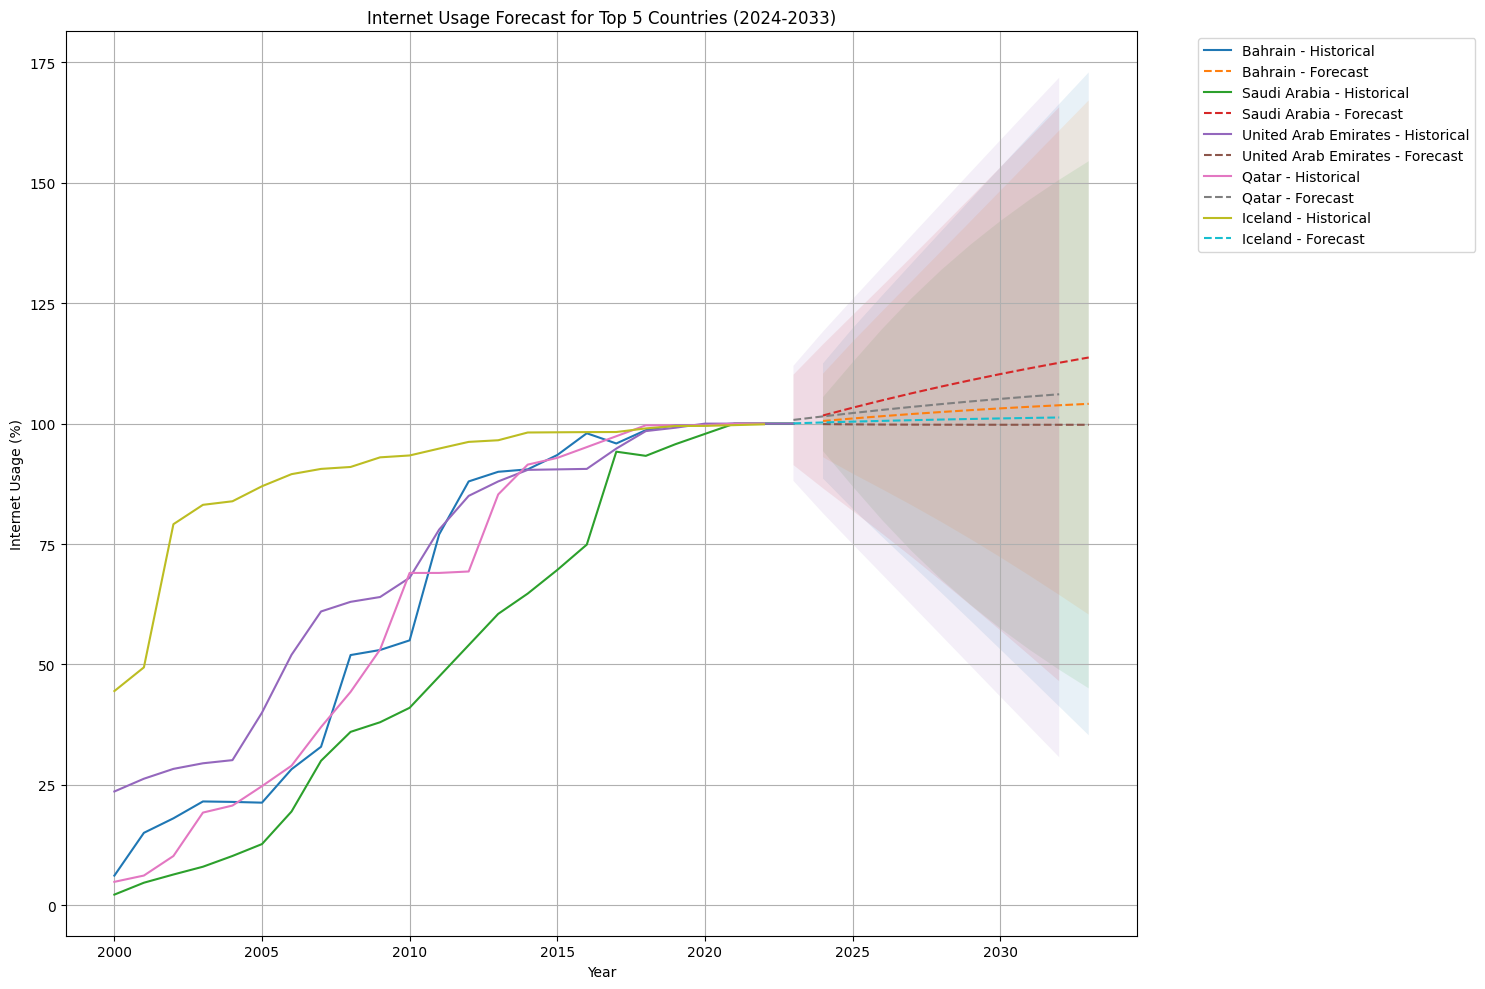

In [42]:
plt.figure(figsize=(15, 10))
for i, country in enumerate(top_5_countries, 1):
    preds, conf_int, last_year = forecast_country(df_long, country)
    if preds is None:
        print(f"Could not generate forecast for {country}")
        continue
    
    # Plot historical data
    country_data = df_long[df_long['Country Name'] == country].dropna()
    plt.plot(country_data['Year'], country_data['Internet_Usage'], label=f'{country} - Historical')
    
    # Create future years starting from last historical year + 1
    future_years = range(last_year + 1, last_year + 1 + len(preds))
    
    # Plot forecast
    plt.plot(future_years, preds, '--', label=f'{country} - Forecast')
    plt.fill_between(future_years, 
                    conf_int.iloc[:,0], 
                    conf_int.iloc[:,1], 
                    alpha=0.1)

plt.title('Internet Usage Forecast for Top 5 Countries (2024-2033)')
plt.xlabel('Year')
plt.ylabel('Internet Usage (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<a name = "6"></a>
# 6. Display forecast values in a table

In [43]:
print("\nForecasted Internet Usage (% of population):")
forecast_table = []
for country in top_5_countries:
    preds, _, last_year = forecast_country(df_long, country)
    if preds is not None:
        forecast_years = range(last_year + 1, last_year + 1 + len(preds))
        for year, val in zip(forecast_years, preds):
            forecast_table.append([country, year, round(val, 2)])

forecast_df = pd.DataFrame(forecast_table, columns=['Country', 'Year', 'Predicted Usage'])
print(forecast_df.pivot(index='Year', columns='Country', values='Predicted Usage'))


Forecasted Internet Usage (% of population):
Country  Bahrain  Iceland   Qatar  Saudi Arabia  United Arab Emirates
Year                                                                 
2023         NaN   100.06  100.77           NaN                   NaN
2024      100.55   100.24  101.50        101.69                 99.90
2025      101.07   100.41  102.20        103.30                 99.84
2026      101.55   100.57  102.85        104.83                 99.81
2027      101.99   100.71  103.47        106.30                 99.79
2028      102.41   100.84  104.05        107.69                 99.78
2029      102.80   100.97  104.61        109.02                 99.77
2030      103.16   101.08  105.13        110.28                 99.77
2031      103.50   101.18  105.63        111.49                 99.76
2032      103.82   101.28  106.10        112.64                 99.76
2033      104.11      NaN     NaN        113.73                 99.76


# Thank You!